* Semi_Supervised Learning : have plenty of unlabeled instances and very few labeled instances.

#  *we’ll use the digits dataset, which is a simple MNIST-like dataset containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9*.



In [1]:
import numpy as np
from sklearn.cluster import KMeans


# Loading the Data:

In [2]:
from sklearn.datasets import load_digits

# "return_X_y=True" : return the data splited to x,y.
X_digits, y_digits = load_digits(return_X_y=True)

#  The first 1400 samples are used for training (X_train and y_train), and the other 397 are used for testing (X_test and y_test)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

# Train a Baseline Model :

In [3]:
from sklearn.linear_model import LogisticRegression
n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [4]:
log_reg.score(X_test, y_test)

0.7481108312342569

* The model’s accuracy is just 74.8%. That’s not great

# Training the model on the full training set:

In [5]:
# Train the model on the full training set
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)

# Evaluate the model's accuracy on the test set
log_reg_full.score(X_test, y_test)


0.906801007556675

### Let’s see how we can do better

# Clustering the Training Data:

In [6]:

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

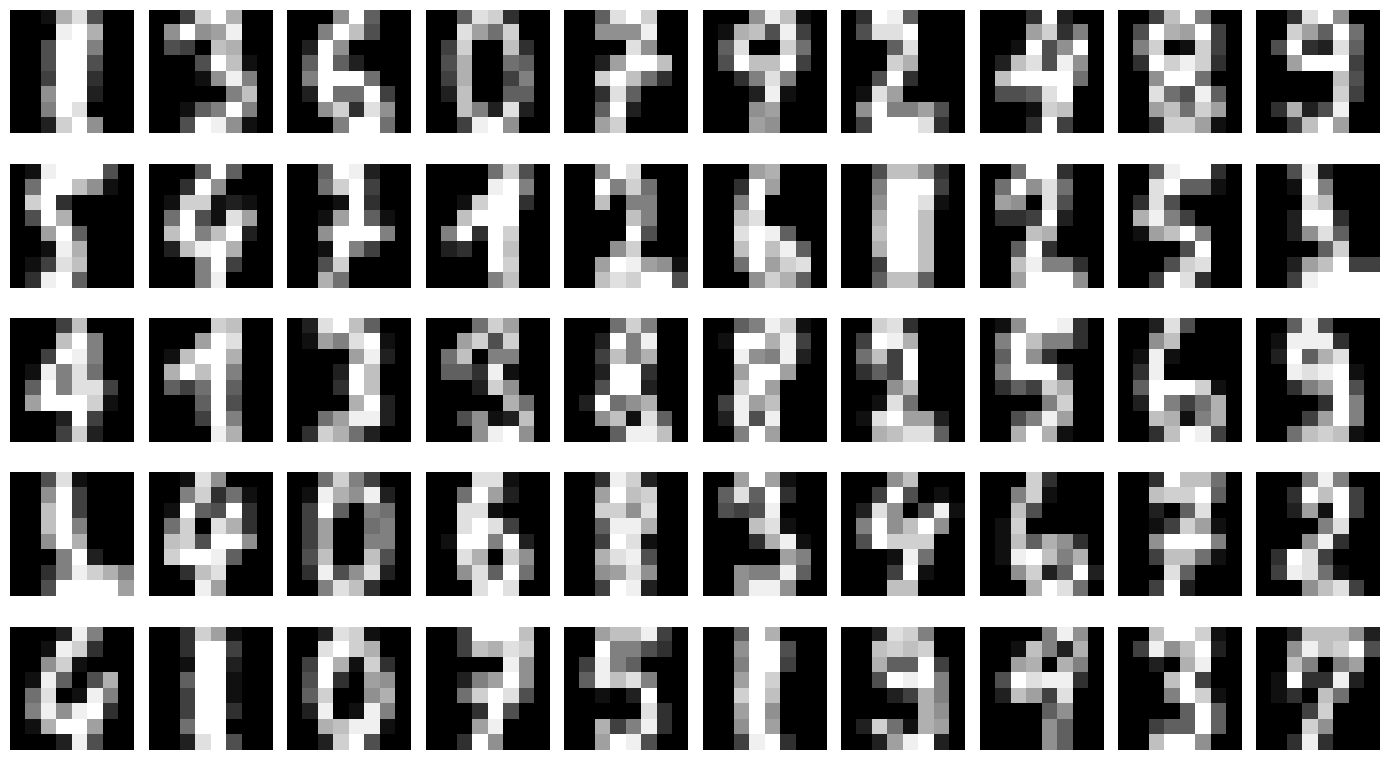

In [17]:
import matplotlib.pyplot as plt
# Assuming each image is originally 8x8 pixels (64 pixels total)
image_size = 8

# Reshape representative images
X_representative_reshaped = X_representative_digits.reshape(-1, image_size, image_size)

# Displaying the representative images
fig, axs = plt.subplots(5, 10, figsize=(14, 8))  # Adjust figsize and subplots based on your preference

for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_representative_reshaped[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

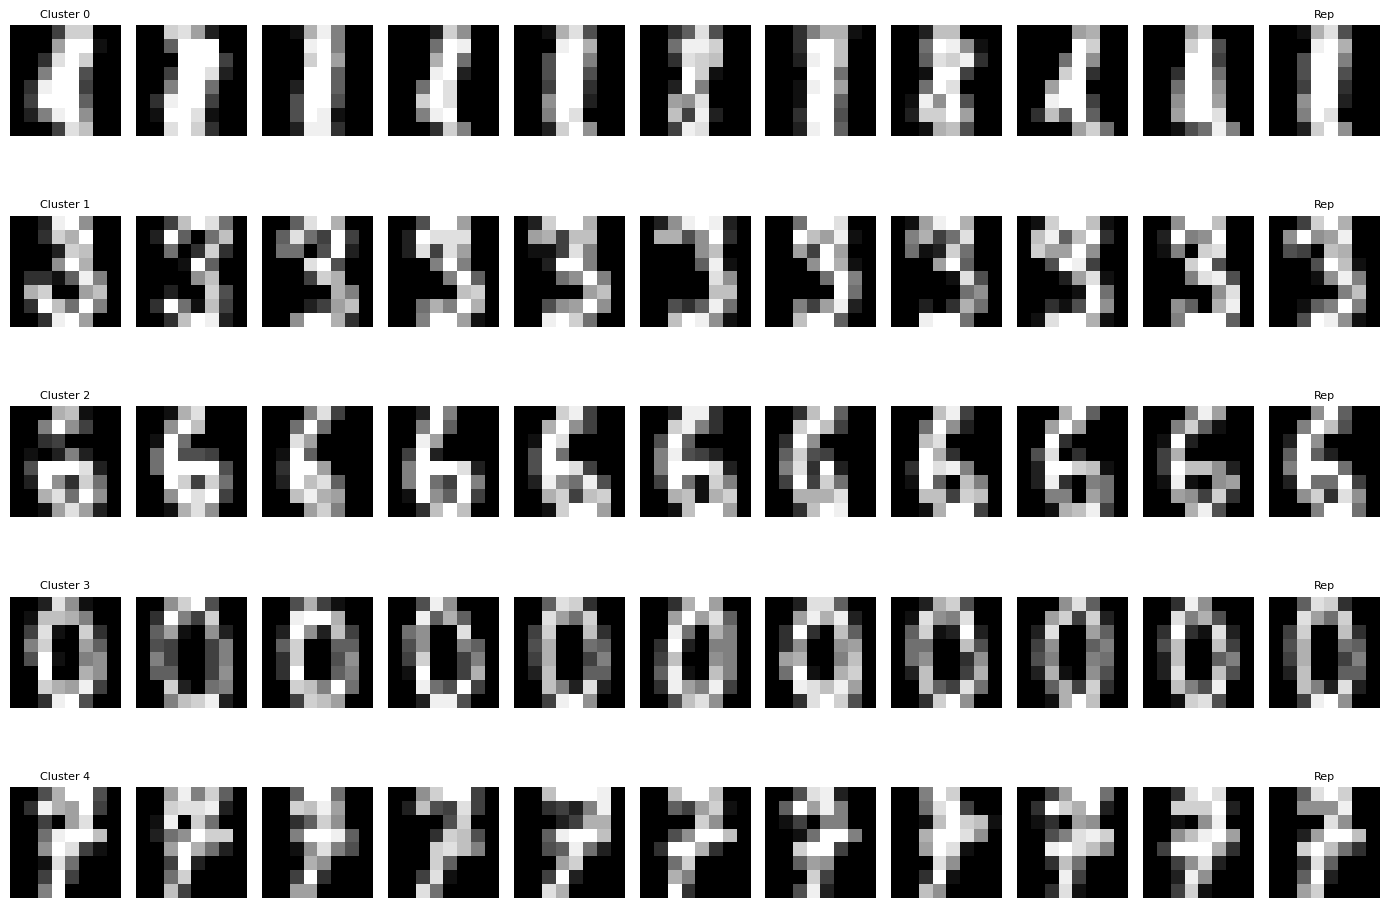

In [18]:
# Plot clusters with representative points
num_clusters_to_plot = 5
fig, axs = plt.subplots(num_clusters_to_plot, 11, figsize=(14, 2 * num_clusters_to_plot))

for cluster_idx in range(num_clusters_to_plot):
    cluster_members = np.where(kmeans.labels_ == cluster_idx)[0]
    selected_members = np.random.choice(cluster_members, 10, replace=False)
    for i, member_idx in enumerate(selected_members):
        ax = axs[cluster_idx, i]
        ax.imshow(X_train[member_idx].reshape(image_size, image_size), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(f"Cluster {cluster_idx}", fontsize=8)

    # Plot the representative image for the cluster
    ax = axs[cluster_idx, -1]
    ax.imshow(X_representative_reshaped[cluster_idx], cmap='gray')
    ax.axis('off')
    ax.set_title("Rep", fontsize=8)

plt.tight_layout()
plt.show()

###  The 50 representative images

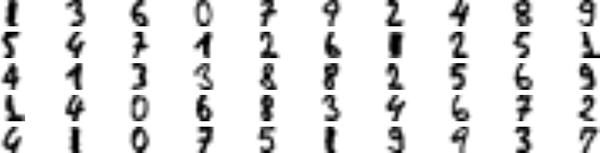

# Manually Labeling Representative Images:

In [7]:
y_representative_digits = np.array([1, 3, 6, 0, 7, 9, 2,4,8,9,5,4,7,1,2,6,1,2,5,1,4,1,3,3,8,8,2,5,6,9,1,4,0,6,8,3,4,6,7,2,4,1,0,7 ,5,1, 9, 9, 3, 7])

# Training on Representative Images:

In [8]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8488664987405542

# Label Propagation:

#### Label Propagation: This technique assumes that instances within the same cluster should share similar labels. 

In [9]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
   y_train_propagated[kmeans.labels_ == i] =y_representative_digits[i]

In [10]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8967254408060453

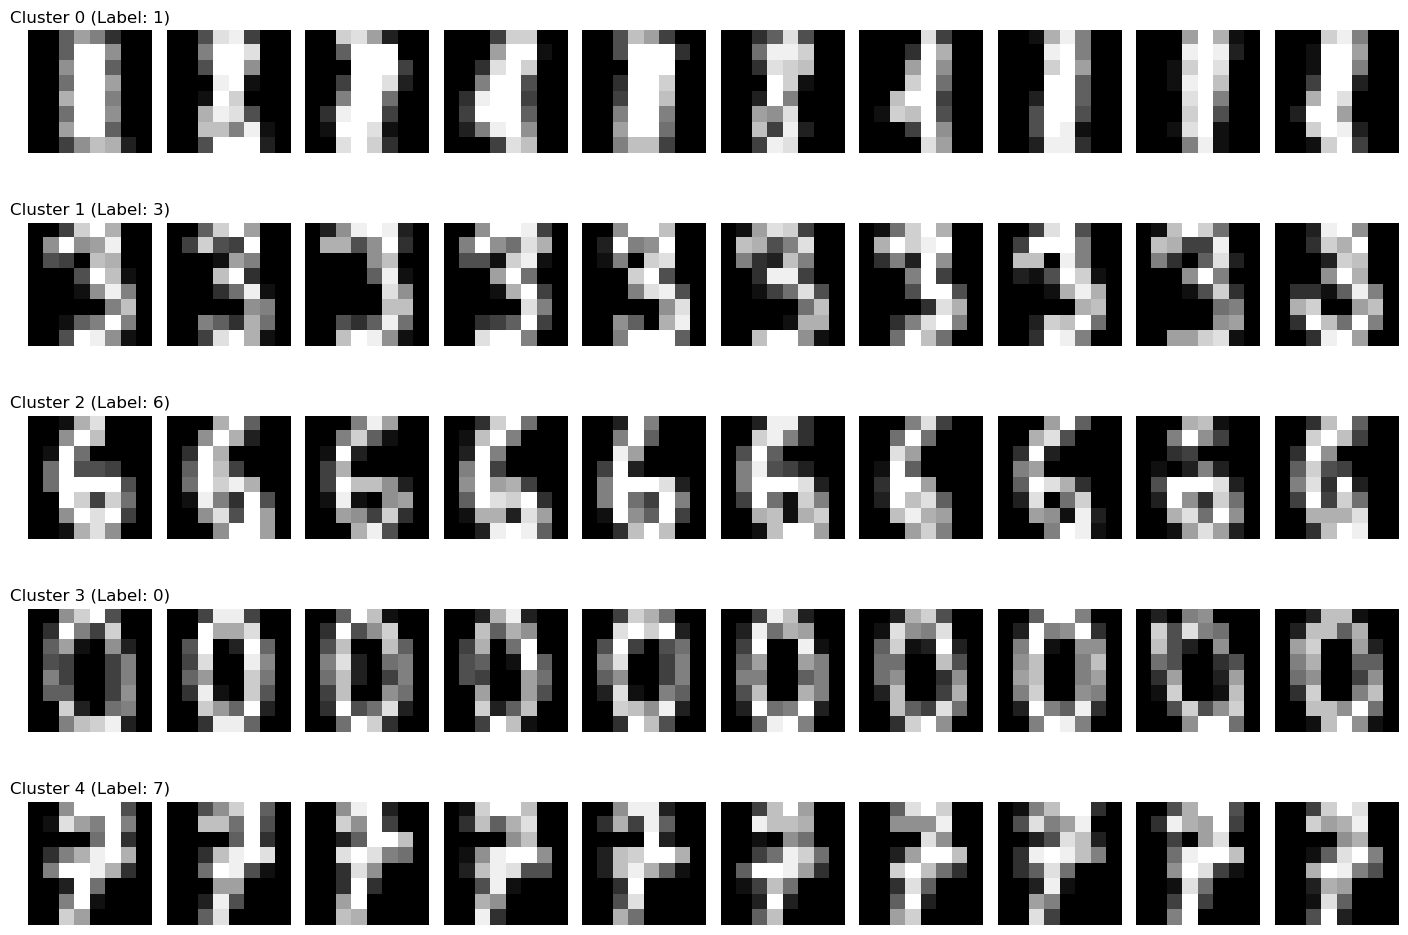

In [16]:
# Visualize label propagation for a few clusters
num_clusters_to_plot = 5
fig, axs = plt.subplots(num_clusters_to_plot, 10, figsize=(14, 2 * num_clusters_to_plot))

for cluster_idx in range(num_clusters_to_plot):
    cluster_members = np.where(kmeans.labels_ == cluster_idx)[0]
    selected_members = np.random.choice(cluster_members, 10, replace=False)
    for i, member_idx in enumerate(selected_members):
        ax = axs[cluster_idx, i]
        ax.imshow(X_train[member_idx].reshape(image_size, image_size), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(f"Cluster {cluster_idx} (Label: {y_representative_digits[cluster_idx]})")

plt.tight_layout()
plt.show()

# Eliminating Outliers:

In [11]:
percentile_closest = 99
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]


In [12]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)  


0.9093198992443325

# Validation of Propagated Labels:

In [13]:
# Calculate accuracy of propagated labels compared to original labels 

(y_train_partially_propagated == y_train[partially_propagated]).mean()  # Output: 97.5% accuracy


0.9755555555555555